# 순환 신경망으로 IMDB 리뷰 분류하기

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/9-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# 경고메세지 안뜨게끔,,
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## IMDB 리뷰 데이터셋

In [3]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=300)  # 단어 300개만

17464789/17464789 [==============================] - 2s 0us/step


In [4]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [6]:
print(len(train_input[0]))  # 첫번째 리뷰의 길이 (토큰 개수)

218


In [7]:
print(len(train_input[1]))  # 두번째 리뷰의 길이

189


In [8]:
print(train_input[0])  # IMDB 리뷰 데이터는 이미 정수로 변환됨. 어휘 사전에 없는 단어는 2로 표시

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 284, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [9]:
print(train_target[:20])  # 부정 0, 긍정 1

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [10]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

#### 리뷰의 길이 확인

In [11]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

In [12]:
print(np.mean(lengths), np.median(lengths))  # 평균 단어 개수와 중간값

239.00925 178.0


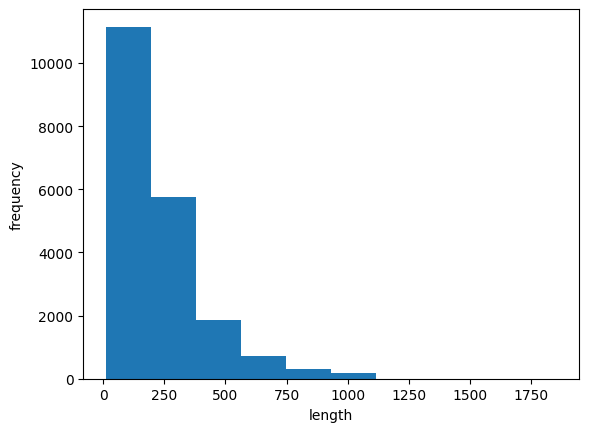

In [13]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

### 시퀀스 데이터의 길이를 맞추는 pad_sequences() 함수
- 지정한 길이보다 길면 잘라내고 짧은 경우는 0으로 패딩
- 긴 시퀀스의 앞부분을 자르는 것이 기본값. 뒷부분을 자르고 싶다면 truncating 매개변수 값을 'pre'가 아니라 'post'로 바꾸면 됨
- 짧은 시퀀스의 앞부분을 0으로 패딩하는 것이 기본값. 뒷부분을 패딩하고 싶다면 padding 매개변수 값을 'pre'가 아니라 'post'로 바꾸면 됨

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)

In [15]:
print(train_seq.shape)

(20000, 100)


In [16]:
print(train_seq[0])  # 첫번째 샘플

[ 10   4  20   9   2   2   2   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


0이 없는걸로 보아 100 단어 이상이었을 것

In [17]:
print(train_input[0][-10:])  # 원본의 끝 10단어 확인

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


샘플 끝 10단어와 완벽히 일치하는 것으로 보아 앞부분이 잘린 것을 알 수 있다

In [18]:
print(train_seq[5])  # 여섯번째 샘플 

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94 205   2  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


앞부분이 0인 것을 보아 원본 샘플의 길이가 100보다 작았을 것

#### 검증 세트의 길이도 100으로 맞춰준다

In [19]:
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기

In [20]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 300)))  # 뉴런 개수 8, 샘플의 길이 100, 단어를 300개로 지정해서
                                                                           # 원-핫 인코딩을 위한 정수값 범위 0~299
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 이진분류니까 sigmoid. 다중분류의 경우 softmax

#### 정수 배열 입력을 자동으로 원-핫 인코딩된 배열로 반환해주는 to_categorical() 함수

In [21]:
train_oh = keras.utils.to_categorical(train_seq) 

In [22]:
print(train_oh.shape)

(20000, 100, 300)


In [23]:
print(train_oh[0][0][:12])  # 열한번째 원소 1

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [24]:
print(np.sum(train_oh[0][0]))  # 잘 인코딩 되었는지(다 합쳐 1인지) 확인

1.0


In [25]:
val_oh = keras.utils.to_categorical(val_seq)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 2472      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
_________________________________________________________________


## 순환 신경망 훈련하기

In [27]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)  # 기본값 말고 0.0001로
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 4s 10ms/step - loss: 0.7003 - accuracy: 0.4999 - val_loss: 0.6970 - val_accuracy: 0.5058
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6956 - accuracy: 0.5124 - val_loss: 0.6946 - val_accuracy: 0.5124
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6917 - accuracy: 0.5288 - val_loss: 0.6909 - val_accuracy: 0.5316
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6843 - accuracy: 0.5556 - val_loss: 0.6832 - val_accuracy: 0.5690
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6783 - accuracy: 0.5778 - val_loss: 0.6792 - val_accuracy: 0.5742
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6730 - accuracy: 0.5923 - val_loss: 0.6755 - val_accuracy: 0.5846
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6679 - accuracy: 0.6052 - val_loss: 0.6695 - val_accuracy: 0.597

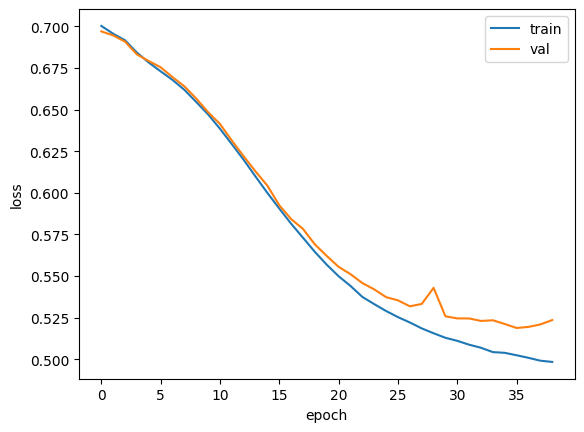

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 단어 임베딩을 사용하기

In [29]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(300, 16, input_length=100))  # 임베딩 벡터 크기 16, 입력 시퀀스의 길이 == 샘플 길이
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           4800      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5,009
Trainable params: 5,009
Non-trainable params: 0
_________________________________________________________________


In [30]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6892 - accuracy: 0.5354 - val_loss: 0.6704 - val_accuracy: 0.5876
Epoch 2/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6398 - accuracy: 0.6467 - val_loss: 0.6233 - val_accuracy: 0.6658
Epoch 3/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6050 - accuracy: 0.6938 - val_loss: 0.6001 - val_accuracy: 0.6954
Epoch 4/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5830 - accuracy: 0.7172 - val_loss: 0.5888 - val_accuracy: 0.7022
Epoch 5/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5662 - accuracy: 0.7300 - val_loss: 0.5669 - val_accuracy: 0.7300
Epoch 6/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5525 - accuracy: 0.7411 - val_loss: 0.5535 - val_accuracy: 0.7364
Epoch 7/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5409 - accuracy: 0.7474 - val_loss: 0.5423 - val_accuracy: 0.7414

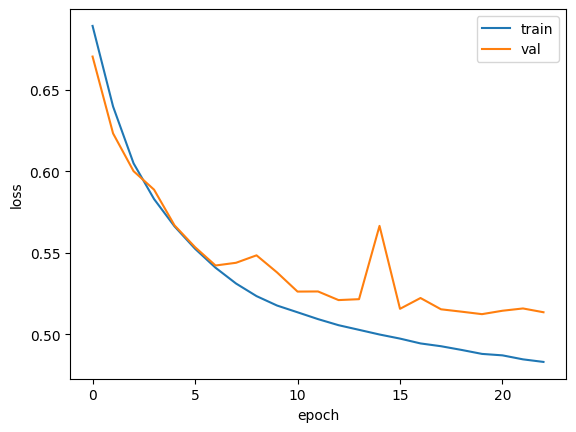

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()